<a href="https://colab.research.google.com/github/MattIzon/16010269_DataAnalytics/blob/main/1_Crime_Aquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set-up
from google.colab import auth, files
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
import pandas as pd
pd.set_option('display.max_columns', None)

Authenticated


In [2]:
# Use big query to get the crime data
client = bigquery.Client(project='assignment-305921')

crime = []

for year in range(2016, 2021):
  crime.append(client.query('''
  SELECT *
  FROM `bigquery-public-data.chicago_crime.crime`
  WHERE year = {}
  ORDER BY date
  '''.format(year)).to_dataframe())

In [3]:
# inspect the data and decide:
# a) Which columns may be useful
# b) Which columns need prep before they can be used - missing data, wrong format etc
crime[0].head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,10366022,HZ101932,2016-01-01 01:00:00+00:00,084XX S EXCHANGE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,423,4,10,46,06,1197281.0,1849663.0,2016,2018-02-10 03:50:01+00:00,41.742332,-87.552736,"(41.742331781, -87.552735548)"
1,10369020,HZ104818,2016-01-01 01:00:00+00:00,015XX W 71ST ST,0497,BATTERY,AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON,APARTMENT,False,True,734,7,17,67,04B,1167272.0,1857644.0,2016,2018-02-10 03:50:01+00:00,41.764927,-87.662460,"(41.764927128, -87.662459997)"
2,10364854,HZ100246,2016-01-01 01:00:00+00:00,003XX E OHIO ST,0320,ROBBERY,STRONGARM - NO WEAPON,SIDEWALK,False,False,1834,18,42,8,03,1178915.0,1904276.0,2016,2018-02-10 03:50:01+00:00,41.892632,-87.618363,"(41.892631803, -87.618362824)"
3,10527261,HZ267921,2016-01-01 01:00:00+00:00,029XX N KEDZIE AVE,0890,THEFT,FROM BUILDING,APARTMENT,False,False,1411,14,35,21,06,1154533.0,1919465.0,2016,2018-02-10 03:50:01+00:00,41.934834,-87.707501,"(41.934834324, -87.707501079)"
4,10366064,HZ102008,2016-01-01 01:00:00+00:00,038XX W HARRISON ST,0460,BATTERY,SIMPLE,CTA TRAIN,False,False,1133,11,24,26,08B,1151141.0,1897093.0,2016,2018-02-10 03:50:01+00:00,41.873511,-87.720554,"(41.873510659, -87.720554136)"


*   At first glance: unique_key, case_number, block, description, arrest, fbi_code, x_coordinate, y_coordinate, year, updated_on dont appear to have any bearing on crime numbers.

*   Types of crime could increase on certain days, however the type of crime cannot be known prior to the event, and staff are required to deal with a crime regardless of its type.  
iucr, primary_type and description can also be removed.

*   location_description could show crime increasing in certain locations on given days, however these location descriptions aren't useful in identifying a geographical area.
location_description can be removed.

*   domestic crime could increase on weekends which would impact crime rates on particular days, however this has similar issues as crime types.
domestic can be removed.

*   date requires reformatting

*   beat, district, ward and community_area provide different levels of location boundary to a crime. 
Crime patterns could emerge in specific locals. A choice of boundary level needs to be made.

*   latitude and longitude / location provide a means of connection with weather data.
location is a reduction of lat / lon. If data is missing one may be used to fill the other.

In [4]:
# Drop the unnecessary fields
no_use = ['unique_key', 'case_number', 'block', 'iucr', 'primary_type',	'description', 'arrest', 'fbi_code', 'x_coordinate', 'y_coordinate', 'year', 'updated_on']
for year in crime:
  year.drop(no_use, axis=1, inplace=True)

In [5]:
# Check for missing data
index = 0
for year in crime:
  print('Missing Data ', 2016 + index, ':')
  for column in year:
    print('  ', column, ': ', year[column].isna().any())
  index += 1
  print()

Missing Data  2016 :
   date :  False
   location_description :  True
   domestic :  False
   beat :  False
   district :  False
   ward :  False
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2017 :
   date :  False
   location_description :  True
   domestic :  False
   beat :  False
   district :  True
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2018 :
   date :  False
   location_description :  True
   domestic :  False
   beat :  False
   district :  False
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2019 :
   date :  False
   location_description :  True
   domestic :  False
   beat :  False
   district :  False
   ward :  True
   community_area :  False
   latitude :  True
   longitude :  True
   location :  True

Missing Data  2020 :
   date :  False
   location_description : 



*   location_description, district (2017), ward (2017/2018/2019/2020), community_area (2020), latitude, longitude and location have missing data

*   district, ward and community_area are linked

*   latitude, longitude and location are linked

In [46]:
# Inspect missing data
index = 0
for year in crime:
  print(2016 + index, ':')
  total_rows = year.shape[0]
  print('Total rows: ', total_rows)
  missing_columns = ['location_description', 'district', 'ward', 'community_area', 'latitude', 'longitude', 'location']
  for column in missing_columns:
    missing_count = sum(year[column].isna())
    print(column, ' missing count: ', missing_count, ' - Percentage of total: ', (missing_count/total_rows)*100)
  index += 1
  print()

2016 :
Total rows:  269709
location_description  missing count:  1276  - Percentage of total:  0.4731024919450222
district  missing count:  0  - Percentage of total:  0.0
ward  missing count:  0  - Percentage of total:  0.0
community_area  missing count:  0  - Percentage of total:  0.0
latitude  missing count:  0  - Percentage of total:  0.0
longitude  missing count:  0  - Percentage of total:  0.0


KeyError: ignored

*   latitude, longitude and location have equal numbers of missing data. If the missing items are all in the same rows the location column is not required.

*   Potentially district, ward and community_area can be patched using each other's values. Further inspection to determine their usefulness should be completed first.

In [7]:
# Check if latitude, longitude and location's missing data are all in the same rows.
index = 0
for year in crime:
  print(sum(year['latitude'].isna() & year['longitude'].isna() & year['location'].isna()))
  index += 1
  print()

2454

4009

5148

1896

3300



* Figures match for each year, therefore all missing from the same row. Location column can be dropped.

In [8]:
# Drop the location field
no_use = ['location']
for year in crime:
  year.drop(no_use, axis=1, inplace=True)

In [9]:
crime[0].head()

,date,location_description,domestic,beat,district,ward,community_area,latitude,longitude
0,2016-01-01 01:00:00+00:00,RESIDENCE,False,423,4,10,46,41.742332,-87.552736
1,2016-01-01 01:00:00+00:00,APARTMENT,True,734,7,17,67,41.764927,-87.662460
2,2016-01-01 01:00:00+00:00,SIDEWALK,False,1834,18,42,8,41.892632,-87.618363
3,2016-01-01 01:00:00+00:00,APARTMENT,False,1411,14,35,21,41.934834,-87.707501
4,2016-01-01 01:00:00+00:00,CTA TRAIN,False,1133,11,24,26,41.873511,-87.720554


In [10]:
# Inspect beat, district, ward, community_area
index = 0
for year in crime:
  print(2016 + index, ':')
  columns = ['beat', 'district', 'ward', 'community_area']
  for column in columns:
    unique_count = year[column].nunique()
    print(column, ' unique count: ', unique_count)
  index += 1
  print()

2016 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2017 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2018 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2019 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77

2020 :
beat  unique count:  274
district  unique count:  23
ward  unique count:  50
community_area  unique count:  77



* Identical figures for each year suggest these are the total numbers of each beat, district, ward and community_area

* beat has the largest number of unique values (274) and so must be the narrowest area.
As the smallest area, the average latitude / longitude per beat is the best solution available to fill the missing data in those columns.

* district has the lowest number of unique values (23) and so must be the widest area.
This could be useful for the DNN, however the missing row in 2017 will need addressing 

In [11]:
# Fill missing latitude / longitude data
for year in crime:
  beats = year['beat'].unique().tolist()

  for beat in beats:
    year.loc[(year['beat'] == beat) & (year['latitude'].isnull()), 'latitude'] = year[year['beat'] == beat]['latitude'].mean(axis = 0, skipna = True)
    year.loc[(year['beat'] == beat) & (year['longitude'].isnull()), 'longitude'] = year[year['beat'] == beat]['longitude'].mean(axis = 0, skipna = True)

In [47]:
# Fill missing district in 2017
ward = crime[1].loc[crime[1]['district'].isnull(), 'ward'].values[0]
district = crime[1].loc[crime[1]['ward'] == ward]['district'].mode().values[0]
crime[1].loc[crime[1]['district'].isnull(), 'district'] = district

IndexError: ignored

In [48]:
# Convert the datetime to date column
for year in crime:
  year['date'] = pd.to_datetime(year['date']).dt.date

In [13]:
# Add day_of_week column containing the day of the week: Monday 1 ... Sunday 7
jan_01 = [5, 7, 1, 2, 3]

def get_date_day(date_str):
  return date_str[8:]

for year in range(len(jan_01)):
  curr_date_day = '01'
  curr_d_o_w = jan_01[year]
  d_o_w = []

  for date_str in crime[year]['date']:
    date_day = get_date_day(date_str.strftime('%Y-%m-%d'))
    if date_day != curr_date_day:
      curr_date_day = date_day
      curr_d_o_w += 1
      if curr_d_o_w == 8:
        curr_d_o_w = 1
    d_o_w.append(curr_d_o_w)
  crime[year]['day_of_week'] = d_o_w

In [15]:
# Add day_of_year column containing 0 ... 365/366
for year in crime:
  d_o_y = []
  curr_day = year['day_of_week'][0]
  curr_d_o_y = 1

  for day in year['day_of_week']:
    if day != curr_day:
      curr_day = day
      curr_d_o_y += 1
    d_o_y.append(curr_d_o_y)
  year['day_of_year'] = d_o_y

In [49]:
crime[0]

,date,location_description,domestic,beat,district,ward,community_area,latitude,longitude,day_of_week,day_of_year
0,2016-01-01,RESIDENCE,False,423,4,10,46,41.742332,-87.552736,5,1
1,2016-01-01,APARTMENT,True,734,7,17,67,41.764927,-87.662460,5,1
2,2016-01-01,SIDEWALK,False,1834,18,42,8,41.892632,-87.618363,5,1
3,2016-01-01,APARTMENT,False,1411,14,35,21,41.934834,-87.707501,5,1
4,2016-01-01,CTA TRAIN,False,1133,11,24,26,41.873511,-87.720554,5,1
...,...,...,...,...,...,...,...,...,...,...,...
269704,2016-12-31,STREET,False,331,3,5,43,41.772618,-87.568319,6,366
269705,2016-12-31,CTA TRAIN,False,113,1,42,32,41.879203,-87.626114,6,366
269706,2016-12-31,APARTMENT,True,633,6,8,44,41.730845,-87.604681,6,366
269707,2016-12-31,CONVENIENCE STORE,False,1512,15,29,25,41.887216,-87.765522,6,366


In [ ]:
for year in crime:
  year['total_crimes'] = crime[0].date.map(crime[0].date.value_counts())

In [ ]:
crime[0].head()

,date,iucr,primary_type,location_description,domestic,beat,district,ward,community_area,latitude,longitude,day_of_year,day_of_week,total_crimes
0,2016-01-01,0620,BURGLARY,APARTMENT,False,1923,19,44,6,41.949534,-87.661660,1,5,1173
1,2016-01-01,0820,THEFT,CTA TRAIN,False,1114,11,28,26,41.885488,-87.726422,1,5,1173
2,2016-01-01,0820,THEFT,STREET,False,1222,12,2,27,41.882914,-87.694674,1,5,1173
3,2016-01-01,1320,CRIMINAL DAMAGE,STREET,False,332,3,5,43,41.768906,-87.577604,1,5,1173
4,2016-01-01,2820,OTHER OFFENSE,RESIDENCE,False,724,7,17,68,41.773529,-87.651911,1,5,1173


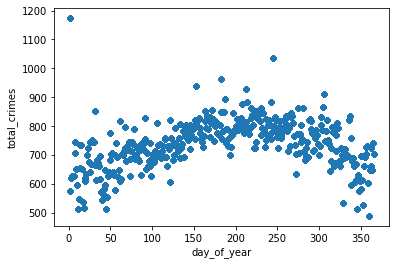

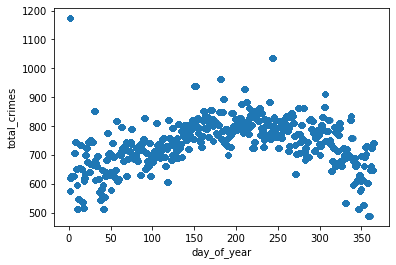

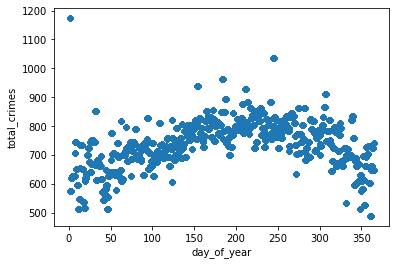

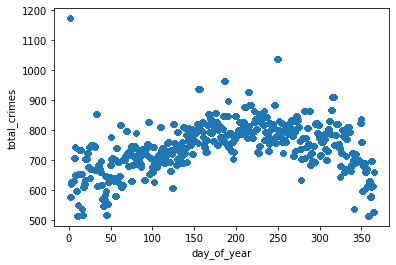

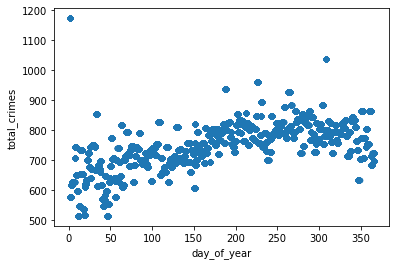

In [ ]:
for year in crime:
  year.plot(x = 'day_of_year', y = 'total_crimes', kind = 'scatter')

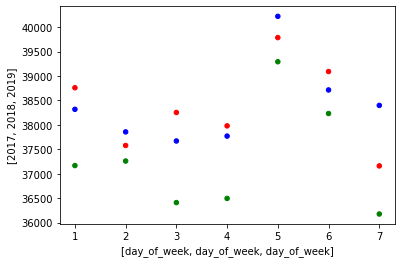

In [ ]:
day__num_crimes = pd.DataFrame({
    'day_of_week': crime[1]['day_of_week'].drop_duplicates().sort_values(),
    # '2016': crime[0]['day_of_year'].value_counts().sort_index(ascending=True).tolist(),
    '2017': crime[1]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    '2018': crime[2]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    '2019': crime[3]['day_of_week'].value_counts().sort_index(ascending=True).tolist(),
    # '2020': crime[4]['day_of_year'].value_counts().sort_index(ascending=True).tolist()
})
day__num_crimes.plot.scatter(x = ['day_of_week', 'day_of_week', 'day_of_week'], y = [ '2017', '2018', '2019',], c = ['blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green','blue', 'red', 'green',])

In [ ]:
# Save crime data to CSV files.

names = ['c_2016', 'c_2017', 'c_2018', 'c_2019', 'c_2020']

# for index in range(len(names)):
#   with open('/gdrive/My Drive/assignment/data/crime/{}.csv'.format(names[index]), 'w') as f:
#     crime[index].to_csv(f)

for index in range(len(names)):
  crime[index].to_csv('{}.csv'.format(names[index])) 
  files.download('{}.csv'.format(names[index]))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>